## Лабораторна робота 5 - Нейро мережі.

У цій роботі Ви побудуєте нейронну мережу для класифікації зображень рукописних символів за датасетом MNIST.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

У файлі **mnist.npz** міститься датасет MNIST. Завантажимо його та візуалізуємо.

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


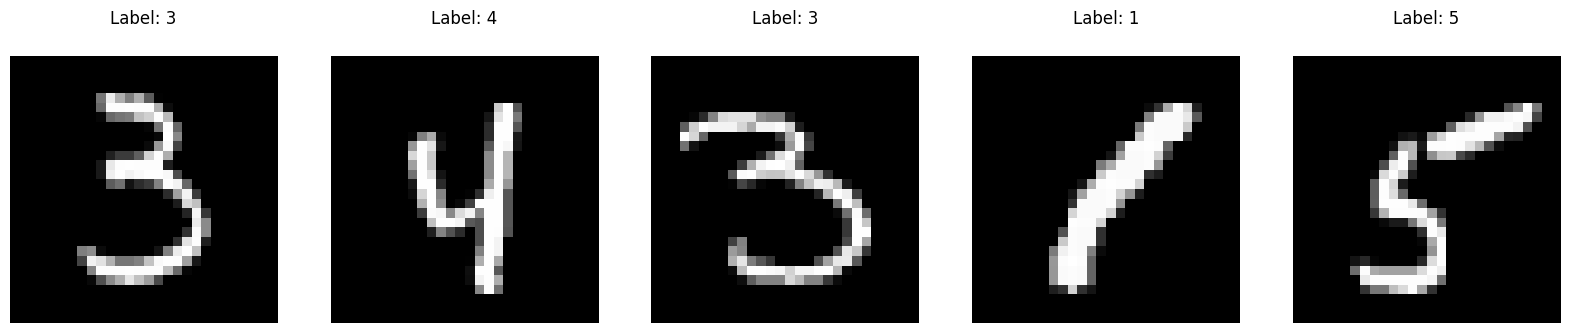

In [3]:
with np.load('mnist.npz') as npz:
    x_train, y_train, x_test, y_test = [npz[k] for k in ['x_train', 'y_train', 'x_test', 'y_test']]

fig, ax = plt.subplots(figsize=(20, 4),  ncols=5)
for a in ax:
    i = np.random.randint(x_train.shape[0])
    a.matshow(x_train[i], cmap='gray')
    a.set_title(f'Label: {y_train[i]}')
    a.axis('off')
    
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

Як можна помітити, дані в датасеті MNIST подано у вигляді **тензора** рангу 3 (тензор рангу 1 це вектор, 2 - матриця), або, по-простому, у вигляді тривимірної таблиці. Ми поки що не знаємо алгоритмів, які здатні приймати на вхід такі дані, тому перетворимо весь наш датасет так, щоб кожна картинка була представлена у вигляді вектора довжини $28\cdot28=784$:

In [5]:
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

print(f'x_train shape after reshape: {x_train.shape}')
print(f'x_test shape after reshape: {x_test.shape}')

x_train shape after reshape: (60000, 784)
x_test shape after reshape: (10000, 784)


Таким чином ми отримали датасет, у якому 784 ознаки. Кожна ознака - інтенсивність певного пікселя картинки.

Для більш ефективного зберігання, інтенсивності пікселів представлені цілочисельним типом uint8, який, на жаль, не підходить для виконання логістичної регресії (оскільки він цілочисельний). Перетворюємо дані в float32.

In [6]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

Реалізуйте методи з позначкою `#TODO` класу LogisticRegression:

Метод `preprocess` повинен додавати колонку з одиниць у матрицю $X$. Опціонально - додайте поліноміальні або будь-які інші нелінійні ознаки.

Метод `onehot` повинен виконувати onehot-перетворення:
$$
 \begin{array}{l}
onehot:\ \mathbb{R}\rightarrow \mathbb{R}^{c}\\
\overline{onehot(y_{i} )}_{j} =\begin{cases}
1, & j=y_{i}\\
0, & j\neq y_{i}
\end{cases}
\end{array}
$$
де $c$ - кількість класів.

Метод `h` - гіпотеза:
$$
\begin{array}{l}
h( X) =\sigma ( X\theta )\\
\sigma ( x) =\frac{1}{1+e^{-x}}
\end{array}
$$
Метод `J` повинен обчислювати оціночну функцію логістичної регресії:
$$
J( \theta ) =\frac{1}{m}\sum ^{m}_{i=1}\sum ^{c}_{j=1}( -y_{i,j} \cdot \log( h( x_{i})_j) \ -\ ( 1\ -\ y_{i,j}) \cdot \log( 1\ -\ h( x_{i})_j) +\alpha _{1}\sum ^{N}_{i=1}\sum ^{c}_{j=1} |\hat{\theta }_{i,j} |+\alpha _{2}\sum ^{N}_{i=1}\sum ^{c}_{j=1}\hat{\theta }^{2}_{i,j}
$$
Метод `grad` має обчислювати градієнт $\frac{\partial J}{\partial \theta }$:
$$
{\displaystyle \frac{\partial J}{\partial \theta }} =-{\displaystyle \frac{1}{m}} X^{T} (Y-h(X) )+\begin{bmatrix}
0 &  &  & \\
 & 1 &  & \\
 &  & \ddots  & \\
 &  &  & 1
\end{bmatrix} \times ( \alpha _{1} sign(\theta )+2\alpha _{2} \theta )
$$
Метод `moments` має повертати вектор-рядки $\mu,\sigma$ для середнього і стандартного відхилення кожної колонки. Пам'ятайте, що колонку з одиницями не потрібно нормалізувати, тож відповідні середнє і стандартне відхилення для неї вкажіть рівними 0 і 1 відповідно. Можна використовувати функції 
[np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) і [np.std](https://numpy.org/doc/stable/reference/generated/numpy.std.html).

Метод `normalize` має виконувати нормалізацію $X$ на основі статистик $\mu,\sigma$, що повернув метод **moments**. Для того щоб уникнути ділення на 0, можете до $\sigma$ додати маленьку величину, наприклад $10^{-8}$.

Метод `get_batch` має повертати матриці $X_b, Y_b$ з довільно обраних $b$ елементів вибірки ($b$ у коді - `self.batch_size`).

Метод `fit` виконує оптимізацію $J(\theta)$. Для кращої збіжності реалізуйте алгоритм оптимізації **Momentum**:
$$
\begin{array}{l}
v_t = \gamma v_{t-1} + \alpha\nabla J(\theta_{t-1})\\
\theta_t = \theta_{t-1} - v_t
\end{array}
$$
де $\gamma$ встановіть рівним $0.9$ (можете поекспериментувати з іншими величинами), $v_1=[0]_{N,c}$.

In [23]:
class LogisticRegression:
    def __init__(
        self,
        alpha1,
        alpha2,
        learning_rate,
        batch_size,
        train_steps
    ):
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_steps = train_steps
    
    def preprocess(self, x):
        x = np.hstack((np.ones((x.shape[0], 1)), x))

        poly_features = x[:, 1:] ** 2
        x = np.hstack((x, poly_features))
        return x
    
    def onehot(self, y):
        y_onehot = np.zeros((y.size, y.max() + 1), dtype=np.float32)
        y_onehot[np.arange(y.size), y] = 1
        return y_onehot
    
    def normalize(self, x):
        epsilon = 1e-8
        return (x - self.mu) / (self.sigma + epsilon)

    def moments(self, x):
        mu = np.mean(x, axis=0)
        sigma = np.std(x, axis=0)

        mu[0] = 0
        sigma[0] = 1

        return mu, sigma
    
    def J(self, x, y, theta):
        m = x.shape[0]
        h_x = self.h(x, theta)

        cost = 1 / m * np.sum(-y * np.log(h_x) - (1 - y) * np.log(1 - h_x))
        reg_l1 = self.alpha1 * np.sum(np.abs(theta))
        reg_l2 = self.alpha2 * np.sum(np.square(theta))
        
        return cost + reg_l1 + reg_l2
    
    def h(self, x, theta):
        return 1 / (1 + np.exp(-np.dot(x, theta)))
    
    def grad(self, x, y, theta):
        m = x.shape[0]
        h_x = self.h(x, theta)

        gradient = -1 / m * np.dot(x.T, (y - h_x))
        reg_l1 = self.alpha1 * np.sign(theta)
        reg_l2 = 2 * self.alpha2 * theta

        return gradient + reg_l1 + reg_l2
    
    def get_batch(self, x, y):
        random_indices = np.random.choice(x.shape[0], self.batch_size, replace=False)
        return x[random_indices], y[random_indices]
    
    def fit(self, x, y):
        x = self.preprocess(x)
        y = self.onehot(y)

        (m, n), (_, c) = x.shape, y.shape
        
        self.mu, self.sigma = self.moments(x)
        x = self.normalize(x)
        
        theta = np.zeros(shape=(n, c))
        v_t = np.zeros((n, c))
        gamma = 0.9
        for step in range(self.train_steps):
            x_batch, y_batch = self.get_batch(x, y)
            theta_grad = self.grad(x_batch, y_batch, theta)

            v_t = gamma * v_t + self.learning_rate * theta_grad
            theta = theta - v_t

        self.theta = theta
        return self

    def predict(self, x):
        x = self.preprocess(x)
        x = self.normalize(x)
        return self.h(x, self.theta).argmax(axis=1)
    
    def score(self, x, y):
        y_pred = self.predict(x)
        return (y == y_pred).mean()


In [29]:
reg = LogisticRegression(0, 0, 1e-3, 32, 1000).fit(x_train, y_train)
print(f'Test accuracy: {reg.score(x_test, y_test) * 100}%')

Test accuracy: 86.8%


Отримана точність на тестовій вибірці має приблизно дорівнювати $88\%\ (!)$.

Виконайте оптимізацію параметрів $\alpha_1,\alpha_2$ за аналогією з лабораторною №2.

Візуалізуйте матрицю помилок для кращої моделі:

alpha1: 0.0001, alpha2: 0.0001, accuracy: 0.8671
alpha1: 0.0001, alpha2: 0.001, accuracy: 0.8711
alpha1: 0.0001, alpha2: 0.01, accuracy: 0.8663
alpha1: 0.0001, alpha2: 0.1, accuracy: 0.8555
alpha1: 0.0001, alpha2: 1.0, accuracy: 0.8325
alpha1: 0.001, alpha2: 0.0001, accuracy: 0.8663
alpha1: 0.001, alpha2: 0.001, accuracy: 0.8679
alpha1: 0.001, alpha2: 0.01, accuracy: 0.8658
alpha1: 0.001, alpha2: 0.1, accuracy: 0.8511
alpha1: 0.001, alpha2: 1.0, accuracy: 0.8153
alpha1: 0.01, alpha2: 0.0001, accuracy: 0.8451
alpha1: 0.01, alpha2: 0.001, accuracy: 0.8534
alpha1: 0.01, alpha2: 0.01, accuracy: 0.8511
alpha1: 0.01, alpha2: 0.1, accuracy: 0.8359
alpha1: 0.01, alpha2: 1.0, accuracy: 0.8003
alpha1: 0.1, alpha2: 0.0001, accuracy: 0.5286
alpha1: 0.1, alpha2: 0.001, accuracy: 0.5593
alpha1: 0.1, alpha2: 0.01, accuracy: 0.5295
alpha1: 0.1, alpha2: 0.1, accuracy: 0.5789
alpha1: 0.1, alpha2: 1.0, accuracy: 0.6251
alpha1: 1.0, alpha2: 0.0001, accuracy: 0.3513
alpha1: 1.0, alpha2: 0.001, accuracy: 0.

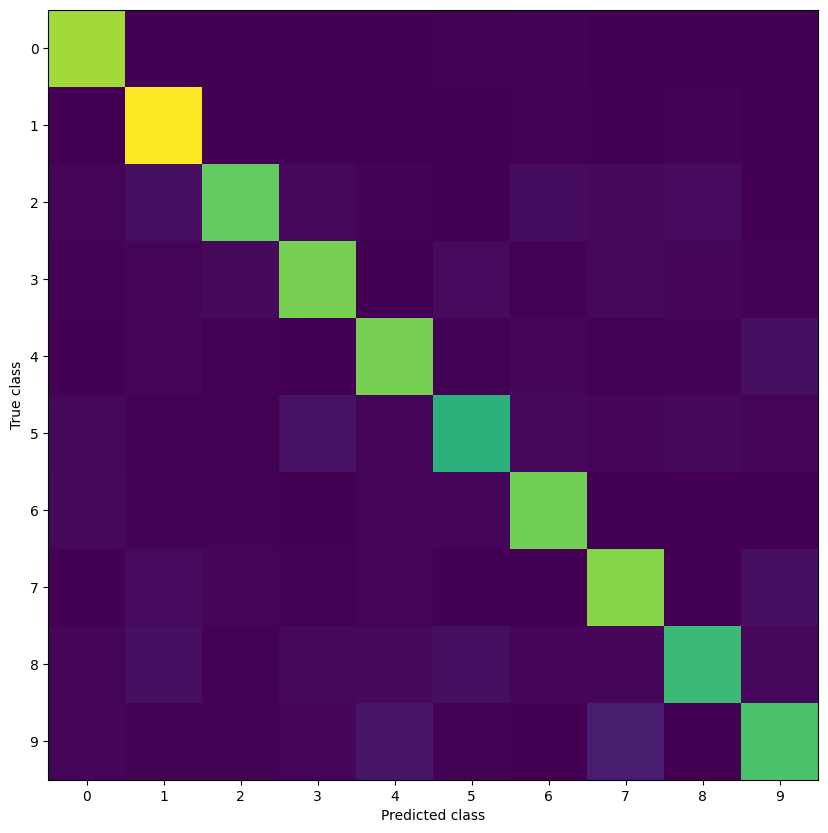

Final accuracy 86.98%


In [32]:
# pip install scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid

alpha_values = 10 ** np.linspace(-4, 0, 5)
param_grid = {'alpha1': alpha_values, 'alpha2': alpha_values}
best_accuracy = 0
best_params = {}
best_model = None

for params in ParameterGrid(param_grid):
    alpha1 = params['alpha1']
    alpha2 = params['alpha2']
    reg = LogisticRegression(alpha1, alpha2, 1e-3, 32, 1000).fit(x_train, y_train)

    accuracy = reg.score(x_test, y_test)
    print(f"alpha1: {alpha1}, alpha2: {alpha2}, accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = reg

print(f"Найкращі параметри - alpha1: {best_params['alpha1']}, alpha2: {best_params['alpha2']}, точність: {best_accuracy}")
reg = LogisticRegression(best_params['alpha1'], best_params['alpha2'], 1e-3, 32, 1000).fit(x_train, y_train)

y_test_pred = reg.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

print(f'Final accuracy {reg.score(x_test, y_test) * 100}%')